In [3]:
import pandas as pd  
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("2017.csv")
print("Le fichier a " + str(df.shape[0]) + " lignes et " + str(df.shape[1]) + " colonnes")

Le fichier a 155 lignes et 12 colonnes


In [5]:
#Liste des colonnes et leur type 
df.dtypes

Country                           object
Happiness.Rank                     int64
Happiness.Score                  float64
Whisker.high                     float64
Whisker.low                      float64
Economy..GDP.per.Capita.         float64
Family                           float64
Health..Life.Expectancy.         float64
Freedom                          float64
Generosity                       float64
Trust..Government.Corruption.    float64
Dystopia.Residual                float64
dtype: object

In [6]:
# 5 premières lignes du dataset
df.head(5)

Country  Happiness.Rank  Happiness.Score  Whisker.high  Whisker.low  \
0       Norway               1            7.537      7.594445     7.479556   
1      Denmark               2            7.522      7.581728     7.462272   
2      Iceland               3            7.504      7.622030     7.385970   
3  Switzerland               4            7.494      7.561772     7.426227   
4      Finland               5            7.469      7.527542     7.410458   

   Economy..GDP.per.Capita.    Family  Health..Life.Expectancy.   Freedom  \
0                  1.616463  1.533524                  0.796667  0.635423   
1                  1.482383  1.551122                  0.792566  0.626007   
2                  1.480633  1.610574                  0.833552  0.627163   
3                  1.564980  1.516912                  0.858131  0.620071   
4                  1.443572  1.540247                  0.809158  0.617951   

   Generosity  Trust..Government.Corruption.  Dystopia.Residual  
0    0.362012                       0.315964           2.277027  
1    0.355280                       0.400770           2.313707  
2    0.475540                       0.153527           2.322715  
3    0.290549                       0.367007           2.276716  
4    0.245483                       0.382612           2.430182

https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/ - documentation

!pip install pip


!pip install pandas-profiling

In [7]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- pandas_profiling a éliminé 2 variables : Whisker.high et Whisker.low qui sont fortement corrélées avec Happiness.Score. 
    Effectivement, quand on regarde la définition de ces 2 variables on voit que ces 2 variables correspondent à l’intervalle
    de confiance de Happiness.Score. On peut donc les écarter pour notre analyse. On peut également supprimer Happiness.Rank
- Aucune valeur manquante
- 9 variables numériques et 1 variable textuelle (on avait déjà calculé cette info un peu plus haut)

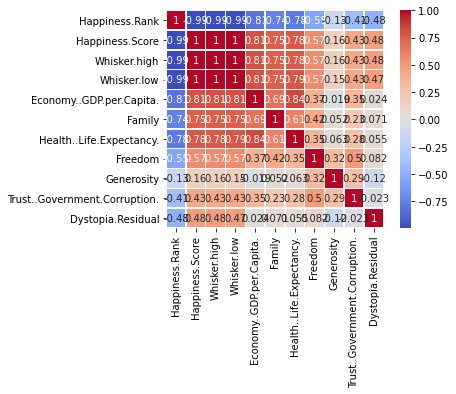

In [9]:
# Matrice des corrélations : 
cor = df.corr() 
sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.5,annot=True );
#Pour choisr la couleur du heatmap : https://matplotlib.org/examples/color/colormaps_reference.html

Constats :

Corrélations avec la variable cible Happiness.score :

Happiness.score est correlé positivement avec Economy.GDP.per.Capita., Family et Health..Life.Expectancy. (donc globalement quand l’indicateur family augmente, Happiness.score augmente aussi)
Happiness.score est correlé négativement avec Generosity
En revanche pour les autres variables la corrélation est plus faible
Corrélations entre les autres variables :

2 variables semblent assez correlées positivement : Health..Life.Expectancy. et Economy..GDP.per.Capita.
Générosite et Dystopia.Residual sont correlées négativement avec la plupart des variables

In [12]:
# On transforme Country en index
pd.DataFrame.set_index(df, 'Country',inplace=True)
# On supprime 3 colonnes
df.drop(columns =['Happiness.Rank','Whisker.high', 'Whisker.low' ], inplace=True)

In [13]:
#On stocke Happiness.Score (la variable à prédire) dans cible
cible = np.array(df['Happiness.Score'])
#On supprime Happiness.Score du dataset
df= df.drop('Happiness.Score', axis = 1)
#On conserve les noms de variable à part
liste_variables = list(df.columns)
#On convertit le dataset en array
df = np.array(df)

In [14]:
#On créé 4 dataset : 
#   - x_train contient 75% de x  
#   - y_train contient le appiness.Score associé à x_train
# => x_train et y_train permettront d'entraîner l'algorithme
#
#   - x_test contient 25% de x  
#   - y_test contient le appiness.Score associé à x_test
# => x_test et y_test permettront d'évaluer la performance de l'algorithme une fois entrainé sur le train
x_train,x_test,y_train,y_test=train_test_split(df,cible,test_size=0.25, random_state=2020)


In [15]:
#On importe l'algorithme à partir de sklearn
from sklearn.ensemble import RandomForestRegressor
#On créé un Random Forest de 100 arbres 
rf = RandomForestRegressor(n_estimators = 100, random_state = 2020)
#Et on lance le training sur notre dataset de train
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=2020)

In [16]:
#On applique le modèle que l'on vient 
#d'entraîner sur l'échantillon de test
predictions = rf.predict(x_test)

In [17]:
#On va calculer plusieurs erreurs entre la valeur prédite et le score de bonheur réel (que nous avions stocké dans y_test)
#     - MAE : Mean Asolute Error
#     - MAPE : Mean Absolute Percentage Error 
# MAE 
erreurs = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(erreurs), 2))

Mean Absolute Error: 0.32


In [18]:
# MAPE
mape = 100 * (erreurs / y_test)
print('Mean Absolute Percentage Error :', round(np.mean(mape), 2), '%.')

Mean Absolute Percentage Error : 6.14 %.


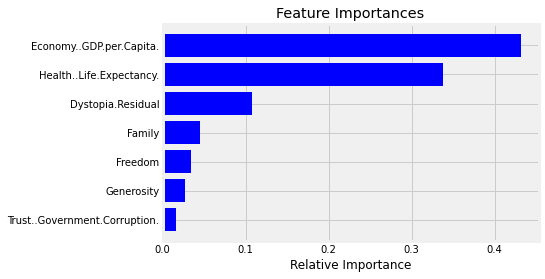

In [20]:
importances = rf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance');